In [1]:
#!pip install rasterio
#!pip install xarray
import rasterio as rio
import xarray as xr
import matplotlib.pyplot as plt
import math
import numpy as np

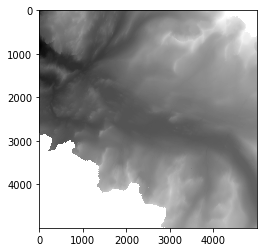

In [2]:
# To change the image, swap fp with a different file path
fp = '/Users/jsnakata/Desktop/School/CHEM E 599/Image Data/TuolumneMeadowsSubset.tif' 
imgnp = xr.open_rasterio(fp).squeeze()
plt.imshow(imgnp, cmap='gray')

## Tiling Function

In [3]:
def tile_slicer(im, shape):
    """Takes image and divides it into multiple tiles with equal specified shape.
    Shape should be a tuple with the desired tile size. Returns as a dicctionary with 
    tile locations as keys of data type tuple. Returns tiled image, preserved shapes for padded tiles,
    and locations for each original tile for stitching."""
    
    if type(shape) != tuple:
        print('The specified shape is not in tuple form.')
        return 
    
    im_shape = np.array(np.shape(im)) # the full shape of the image, tuple
    des_shape = np.array(shape)
    div = im_shape / des_shape
    for i in range(len(div)):
        div[i] = math.ceil(div[i])
    #print(div)
    for i in div: # Ends the function if the tile size is greater than the image
        if i < 1:
            print('The specified tile size is larger than the image.')
            return
    tile_num = int(np.prod(div))
    #print(tile_num, 'Tiles')
    
    shape_iter = list(shape)
    
    tile_dict = {}
    saved_locs = {}
    for i in range(1,int(div[1])+1): # iterates with different tiles locations until the whole image is captured 
        for j in range(1,int(div[0])+1):
            location = tuple([i,j])
            # subset slicing
            # vertical coordinates
            vh = j * shape_iter[0]
            vl = vh - shape_iter[0]
            hh = i * shape_iter[1]
            hl = hh - shape_iter[1]
            # ensures indexing is within the bounds
            if vh > list(im_shape)[0]: 
                vh = list(im_shape)[0]
            if hh > list(im_shape)[1]:
                hh = list(im_shape)[1]
            
            subset = im[vl:vh, hl:hh]
            saved_locs[location] = [vl, vh, hl, hh]
            tile_dict[location] = subset
            
    return tile_dict, saved_locs, im_shape

In [4]:
tiles, locs, orig_shape = tile_slicer(imgnp, (500,500))

## Rolling Window Standard Deviation Function 

In [5]:
def rolling_stdev(im, size):                # im: a DataArray loaded in using xarray. size: define the size (dimension of one side) of your moving window
  """
  Short Summary
  --------------------
  This function calculates the rolling standard deviation within a window of
  specified dimensions.

  Extended Summary
  ------------------
  This function utilizes xarray's rolling window operation to first create a 
  Rolling object, and then to apply that Rolling object to the DataArray
  to calculate standard deviation within each (size, size) window. The output is
  a new DataArray with each pixel populated with the standard deviation of all 
  pixels within the window for which the pixel was at the center. This function
  also outputs a plot of the output file for quick and easy data visualization.

  Parameters
  ------------
  im:   DataArray
        Generally a .tif file that has been loaded in using xarray.open_rasterio()
  size 
        The dimension of the square rolling window to use. If one dimension is supplied, 
        it will be propagated to the proper number of dimensions. For example, a size
        set to 3 will generate a rolling window square of dimensions (3,3).

  Returns
  ------------
  tuple
        consisting of the new DataArray of standard deviation values
        and the figure and axes of the plot of this new DataArray
  
  Example
  -------------
  Implement by saving the output as a variable. 
  >>>output = rolling_stdev(im=im_subset, size=3)
  >>>output[0]
  xarray.DataArray

    band: 1y: 511x: 511

    nan nan nan nan nan ... 0.06020909 0.1668852 0.025760788 0.05106023
    Coordinates:
        band
        (band)
        int64
        1
        y
        (y)
        float64
        4.2e+06 4.2e+06 ... 4.198e+06
        x
        (x)
        float64
        2.272e+05 2.273e+05 ... 2.288e+05
    Attributes: (0)

  """
  
  r = im.rolling(y=size)                    # this creates the xarray Rolling object 
  im_stdev = r.reduce(np.std)               # use the Rolling object to calculate the standard deviation within each window. Could substitute other functions like mean or median. 
  
  return im_stdev

In [6]:
stdev_dict = {}

for key in tiles.keys():
    stdev_dict[key] = rolling_stdev(tiles[key], 3)

## Stitching Function

In [7]:
def tif_stitch(tiles, saved_locs, im_shape):
    """Creates a background mask the size of the original image shape and uses it to stitch the tiles back together.
    """
    
    stitched_im = np.zeros(im_shape)
    for key in saved_locs.keys():
        location = saved_locs[key]
        im = tiles[key]
        
        stitched_im[location[0]:location[1], location[2]:location[3]] = im
    
    return stitched_im

In [8]:
stitched_stdev = tif_stitch(stdev_dict, locs, orig_shape)

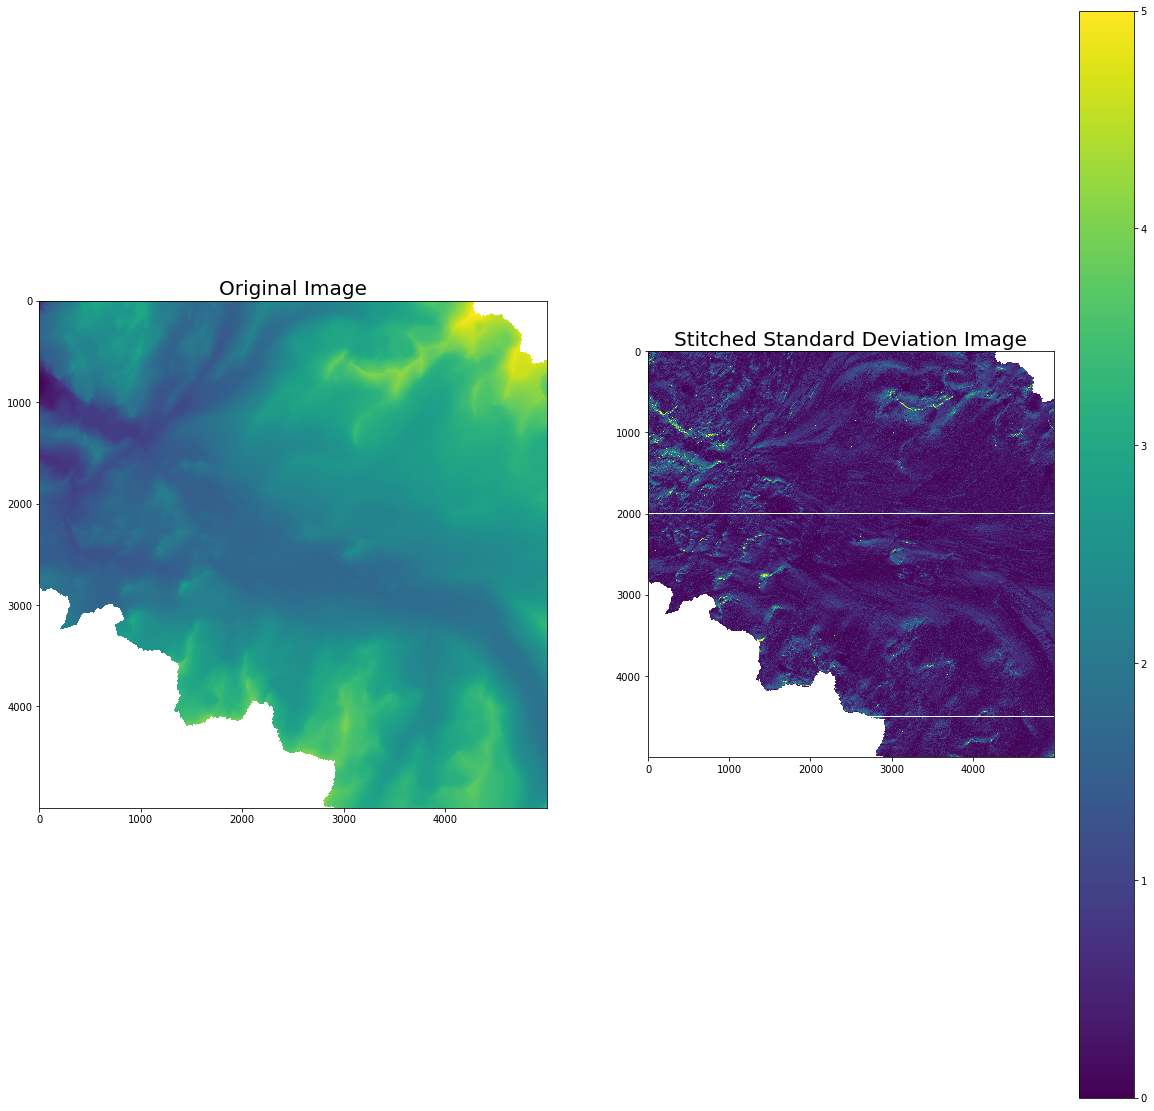

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(20,20))

ax[0].imshow(imgnp)
ax[0].set_title('Original Image', fontsize=20)
c = ax[1].imshow(stitched_stdev, vmin=0, vmax=5)
ax[1].set_title('Stitched Standard Deviation Image', fontsize=20)
plt.colorbar(c)

**What are the white lines?**

It's unknown what causes the white lines in the stitched standard deviation image, but slicing a subset of the image that includes the white lines shows that they aren't really there. As such, it is not something to be concerned about at this time.

In [17]:
out_slope_fp = 'gdal_slope.tif'
!gdaldem slope $fp $out_slope_fp

/bin/sh: gdaldem: command not found
